In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf
from sklearn.svm import SVR
from sklearn.metrics import r2_score

In [2]:
dataset = pd.read_csv("GMM_values.csv", header=0)

In [3]:
#get failure times 
failurePoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        failurePoints.append(row['Timestep'])

In [4]:
def getRUL(current, failurelst):
    nextFailure = None
    for f in failurelst:
        if f - current >= 0: 
            nextFailure = f
            break 
    if nextFailure != None:
        diff = nextFailure - current 
        return diff
    else: 
        return None

In [5]:
#investigate general trend of RUL values 
total_rul = []
timeX = dataset['Timestep'].tolist()
for instance in timeX:
    current_rul = getRUL(instance, failurePoints)
    total_rul.append(current_rul)

In [6]:
#create a new dataframe with RUL 
all_df = dataset.copy(deep=True)
all_df['RUL'] = total_rul
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0
...,...,...,...,...,...,...,...
7995,7995,0.333491,0.682035,0.220176,0.249060,0,NaN
7996,7996,0.344994,0.689298,0.225088,0.218040,1,NaN
7997,7997,0.390017,0.641338,0.211275,0.239294,1,NaN
7998,7998,0.324577,0.656867,0.205467,0.294698,1,NaN


In [7]:
#drop na columns 
all_df = all_df.dropna()
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0
...,...,...,...,...,...,...,...
7987,7987,0.325059,0.616790,0.235959,0.192175,2,4.0
7988,7988,0.388779,0.670864,0.243099,0.248306,2,3.0
7989,7989,0.339885,0.607819,0.237883,0.232814,3,2.0
7990,7990,0.525533,0.611479,0.414174,0.214225,3,1.0


In [8]:
#split data into episodes
data_split = []
chunkBySize = []
for index, row in all_df.iterrows():
    currentRUL = row['RUL']
    arr = [row['Timestep'], row['Volt'], row['Rotate'], row['Pressure'], row['Vibration'], row['RUL'], row['State']]
    if currentRUL < 1:  
        chunkBySize.append(arr)
        if (chunkBySize):
            data_split.append(chunkBySize)
        chunkBySize = []
    else:
        chunkBySize.append(arr)

In [9]:
#split in training, validation and test sets

num_episodes = len(data_split)
num_train = int(0.75*num_episodes)
num_val = int(0.125*num_episodes)

train_data = data_split[:num_train]
val_data = data_split[num_train:num_train+num_val]
test_data = data_split[num_train+num_val:]

In [10]:
#drop episodes with random failure in training set
train_data_cleaned = []
for train_episode in train_data:
    lastState = train_episode[-1][-1]
    if lastState < 5:
        train_data_cleaned.append(train_episode)

In [11]:
def getSensorReadingsOnlyNoEpisode(lst):
    result = []
    time = []
    for episode in lst:
        for row in episode:
            row_formatted = row[1:5]
            result.append(row_formatted)
            time.append(row[0])
    return (result, time)

In [12]:
def getRULFromDataNoEpisode(lst):
    RULresult = []
    for episode in lst:
        for row in episode:
            RULresult.append(row[5])
    return RULresult

In [13]:
#set random seed 
tf.random.set_seed(42)

In [14]:
def findSscore(actualRULlist, predictedRULlist):
    Sscore = 0
    for order in range(len(actualRULlist)):
        actualRUL = actualRULlist[order]
        predictedRUL = predictedRULlist[order]
        diff = abs(actualRUL - predictedRUL)
        if predictedRUL < actualRUL: #underestimate
            multiplier = 1/13
        else: #overestimate
            multiplier = 1/10
        factor = multiplier*diff
        score = math.exp(factor)
        Sscore += score
    return Sscore

### Train with all data

In [15]:
SVR_trainX, SVR_trainTime = getSensorReadingsOnlyNoEpisode(train_data)
SVR_trainY = getRULFromDataNoEpisode(train_data)
SVR_valX, SVR_valTime = getSensorReadingsOnlyNoEpisode(val_data)
SVR_valY = getRULFromDataNoEpisode(val_data)
SVR_testX, SVR_testTime = getSensorReadingsOnlyNoEpisode(test_data)
SVR_testY = getRULFromDataNoEpisode(test_data)

In [16]:
SVR_valTime

[6010.0,
 6011.0,
 6012.0,
 6013.0,
 6014.0,
 6015.0,
 6016.0,
 6017.0,
 6018.0,
 6019.0,
 6020.0,
 6021.0,
 6022.0,
 6023.0,
 6024.0,
 6025.0,
 6026.0,
 6027.0,
 6028.0,
 6029.0,
 6030.0,
 6031.0,
 6032.0,
 6033.0,
 6034.0,
 6035.0,
 6036.0,
 6037.0,
 6038.0,
 6039.0,
 6040.0,
 6041.0,
 6042.0,
 6043.0,
 6044.0,
 6045.0,
 6046.0,
 6047.0,
 6048.0,
 6049.0,
 6050.0,
 6051.0,
 6052.0,
 6053.0,
 6054.0,
 6055.0,
 6056.0,
 6057.0,
 6058.0,
 6059.0,
 6060.0,
 6061.0,
 6062.0,
 6063.0,
 6064.0,
 6065.0,
 6066.0,
 6067.0,
 6068.0,
 6069.0,
 6070.0,
 6071.0,
 6072.0,
 6073.0,
 6074.0,
 6075.0,
 6076.0,
 6077.0,
 6078.0,
 6079.0,
 6080.0,
 6081.0,
 6082.0,
 6083.0,
 6084.0,
 6085.0,
 6086.0,
 6087.0,
 6088.0,
 6089.0,
 6090.0,
 6091.0,
 6092.0,
 6093.0,
 6094.0,
 6095.0,
 6096.0,
 6097.0,
 6098.0,
 6099.0,
 6100.0,
 6101.0,
 6102.0,
 6103.0,
 6104.0,
 6105.0,
 6106.0,
 6107.0,
 6108.0,
 6109.0,
 6110.0,
 6111.0,
 6112.0,
 6113.0,
 6114.0,
 6115.0,
 6116.0,
 6117.0,
 6118.0,
 6119.0,
 6120.0,
 

In [17]:
#change to arr 
SVR_trainX_arr = np.array(SVR_trainX)
SVR_trainY_arr = np.array(SVR_trainY)
SVR_valX_arr = np.array(SVR_valX)
SVR_valY_arr = np.array(SVR_valY)
SVR_testX_arr = np.array(SVR_testX)
SVR_testY_arr = np.array(SVR_testY)

In [18]:
#check shape (training) X
SVR_trainX_arr.shape

(6010, 4)

In [19]:
#check shape (training) Y
SVR_trainY_arr.shape

(6010,)

In [20]:
#check shape (validation) X
SVR_valX_arr.shape

(967, 4)

In [21]:
#check shape (validation) Y
SVR_valY_arr.shape

(967,)

In [22]:
SVRmodel = SVR(kernel='rbf',degree=4,gamma='auto',C=98.818,epsilon=0.978)
SVRmodel.fit(SVR_trainX_arr, SVR_trainY_arr)

SVR(C=98.818, degree=4, epsilon=0.978, gamma='auto')

In [23]:
#evaluate performance of training set 
SVR_trainPredict = SVRmodel.predict(SVR_trainX_arr)
SVR_trainRMSE = math.sqrt(mean_squared_error(SVR_trainY_arr, SVR_trainPredict))
SVR_trainR2Score = r2_score(SVR_trainY_arr, SVR_trainPredict)
SVR_trainSscore = findSscore(SVR_trainY_arr, SVR_trainPredict)
print("RMSE of training set is %f, R2 score of training set is %f, S score of training set is %f" % (SVR_trainRMSE, SVR_trainR2Score, SVR_trainSscore))

RMSE of training set is 4.725065, R2 score of training set is 0.120090, S score of training set is 8427.621502


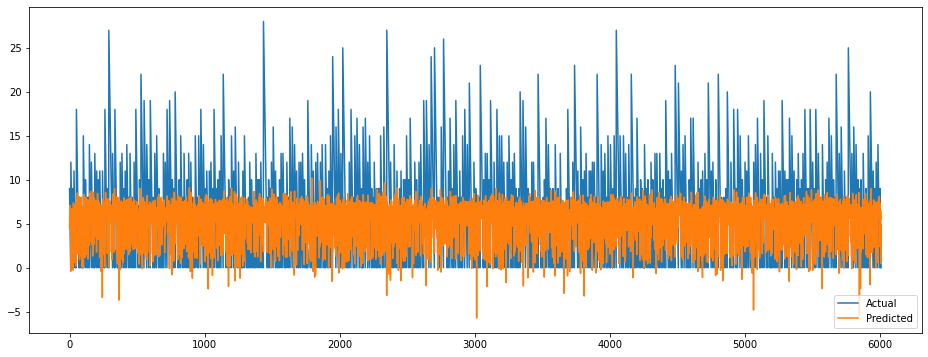

In [24]:
plt.figure(figsize=(16, 6))
plt.plot(SVR_trainY)
plt.plot(SVR_trainPredict)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

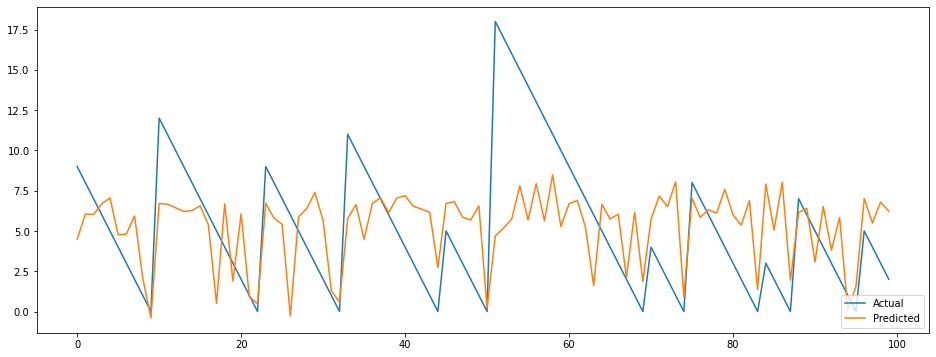

In [25]:
plt.figure(figsize=(16, 6))
plt.plot(SVR_trainY[0:100])
plt.plot(SVR_trainPredict[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

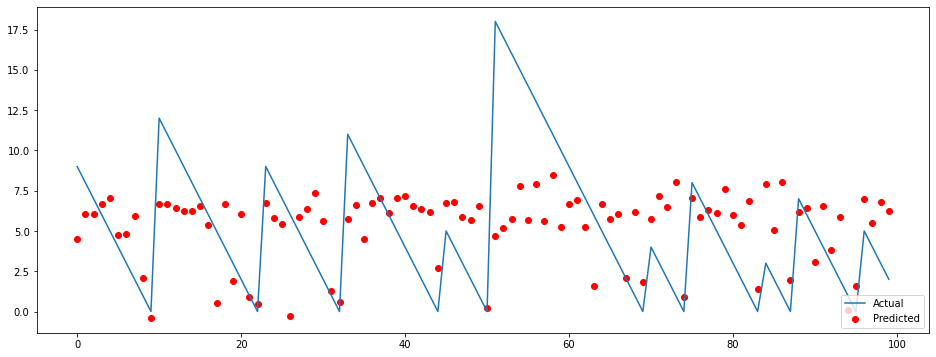

In [26]:
plt.figure(figsize=(16, 6))
plt.plot(SVR_trainTime[0:100], SVR_trainY[0:100])
plt.scatter(SVR_trainTime[0:100], SVR_trainPredict[0:100], color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

In [27]:
#evaluate performance of validation set 
SVR_valPredict = SVRmodel.predict(SVR_valX_arr)
SVR_valRMSE = math.sqrt(mean_squared_error(SVR_valY_arr, SVR_valPredict))
SVR_valR2Score = r2_score(SVR_valY_arr, SVR_valPredict)
SVR_valSscore = findSscore(SVR_valY_arr, SVR_valPredict)
print("RMSE of validation set is %f, R2 score of validation set is %f, S score of validation set is %f" % (SVR_valRMSE, SVR_valR2Score, SVR_valSscore))

RMSE of validation set is 3.848844, R2 score of validation set is 0.187612, S score of validation set is 1291.351149


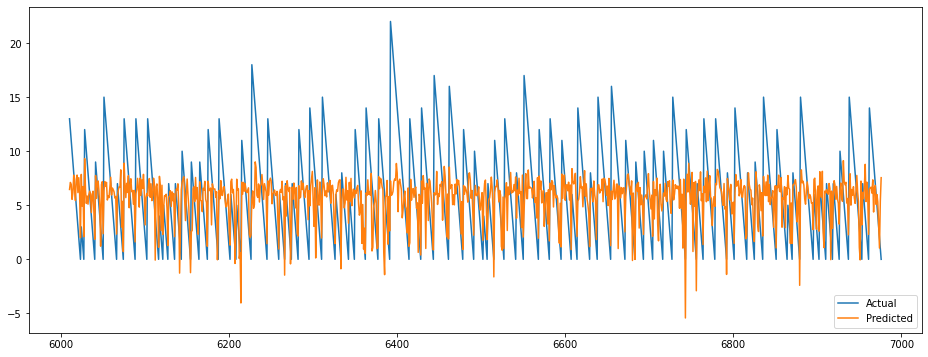

In [28]:
plt.figure(figsize=(16, 6))
plt.plot(SVR_valTime, SVR_valY_arr)
plt.plot(SVR_valTime, SVR_valPredict)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

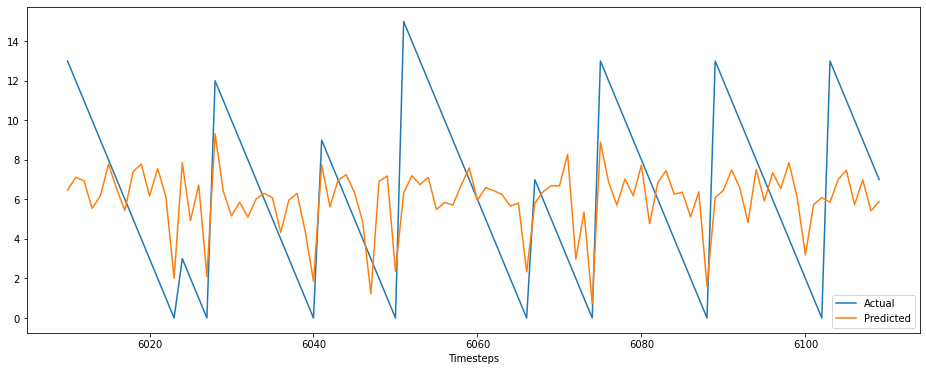

In [46]:
plt.figure(figsize=(16, 6))
plt.plot(SVR_valTime[0:100], SVR_valY_arr[0:100])
plt.plot(SVR_valTime[0:100], SVR_valPredict[0:100])
plt.xlabel('Timesteps')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

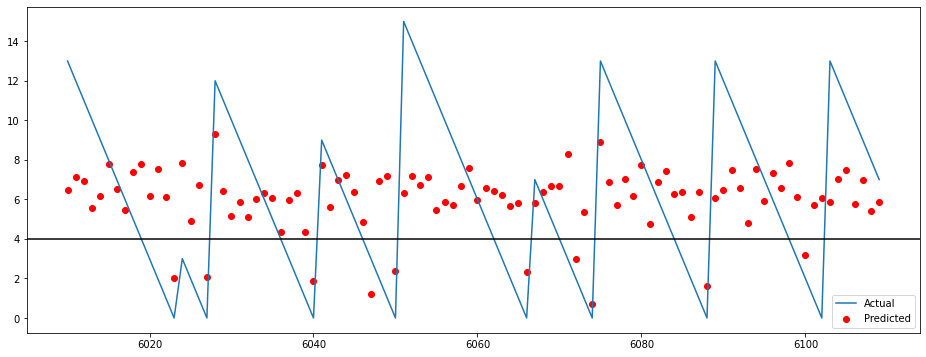

In [30]:
plt.figure(figsize=(16, 6))
plt.plot(SVR_valTime[0:100], SVR_valY_arr[0:100])
plt.scatter(SVR_valTime[0:100], SVR_valPredict[0:100], color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.axhline(y=4, color='k', linestyle='-')
plt.show()

### Train with degradation data only

In [31]:
SVR_trainX_degrad, SVR_trainTime_degrad = getSensorReadingsOnlyNoEpisode(train_data_cleaned)
SVR_trainY_degrad = getRULFromDataNoEpisode(train_data_cleaned)
SVR_valX_degrad, SVR_valTime_degrad = getSensorReadingsOnlyNoEpisode(val_data)
SVR_valY_degrad = getRULFromDataNoEpisode(val_data)
SVR_testX_degrad, SVR_testTime_degrad = getSensorReadingsOnlyNoEpisode(test_data)
SVR_testY_degrad = getRULFromDataNoEpisode(test_data)

In [32]:
#change to arr 
SVR_trainX_degrad_arr = np.array(SVR_trainX_degrad)
SVR_trainY_degrad_arr = np.array(SVR_trainY_degrad)
SVR_valX_degrad_arr = np.array(SVR_valX_degrad)
SVR_valY_degrad_arr = np.array(SVR_valY_degrad)
SVR_testX_degrad_arr = np.array(SVR_testX_degrad)
SVR_testY_degrad_arr = np.array(SVR_testY_degrad)

In [33]:
#check shape (training) X
SVR_trainX_degrad_arr.shape

(5362, 4)

In [34]:
#check shape (training) Y
SVR_trainY_degrad_arr.shape

(5362,)

In [35]:
#check shape (validation) X
SVR_valX_degrad_arr.shape

(967, 4)

In [36]:
#check shape (validation) Y
SVR_valY_degrad_arr.shape

(967,)

In [37]:
SVRmodel2 = SVR(kernel='rbf',degree=4,gamma='auto',C=98.818,epsilon=0.978)
SVRmodel2.fit(SVR_trainX_degrad_arr, SVR_trainY_degrad_arr)

SVR(C=98.818, degree=4, epsilon=0.978, gamma='auto')

In [38]:
#evaluate performance of training set 
SVR_trainPredict2 = SVRmodel2.predict(SVR_trainX_arr)
SVR_trainRMSE2 = math.sqrt(mean_squared_error(SVR_trainY_arr, SVR_trainPredict2))
SVR_trainR2Score2 = r2_score(SVR_trainY_arr, SVR_trainPredict2)
SVR_trainSscore2 = findSscore(SVR_trainY_arr, SVR_trainPredict2)
print("RMSE of training set is %f, R2 score of training set is %f, S score of training set is %f" % (SVR_trainRMSE2, SVR_trainR2Score2, SVR_trainSscore2))

RMSE of training set is 4.701051, R2 score of training set is 0.129011, S score of training set is 8439.396649


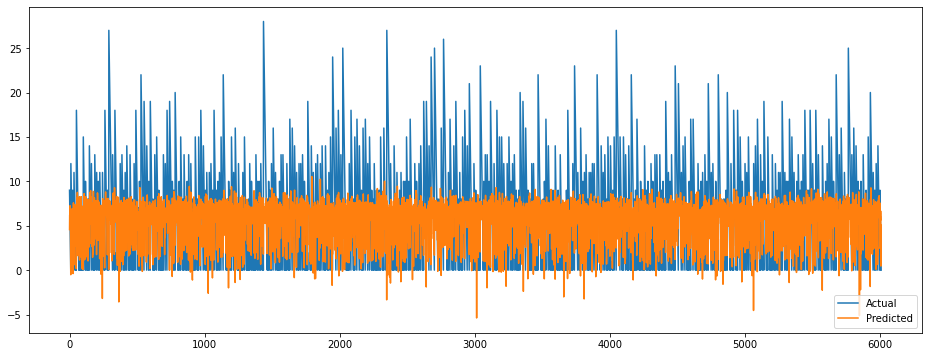

In [39]:
plt.figure(figsize=(16, 6))
plt.plot(SVR_trainY_arr)
plt.plot(SVR_trainPredict2)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

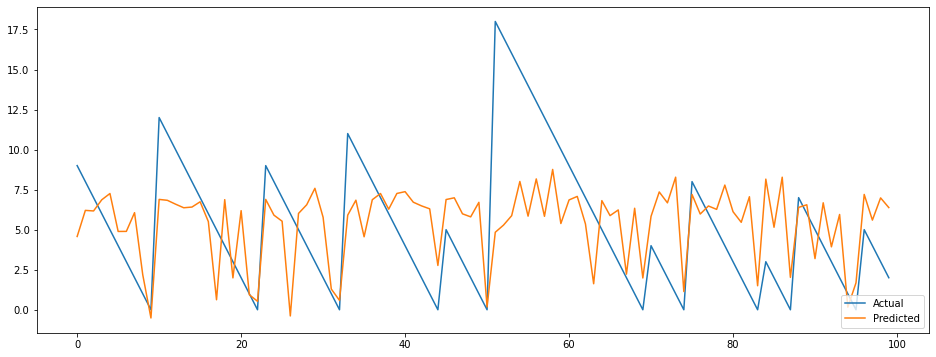

In [40]:
plt.figure(figsize=(16, 6))
plt.plot(SVR_trainY_arr[0:100])
plt.plot(SVR_trainPredict2[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

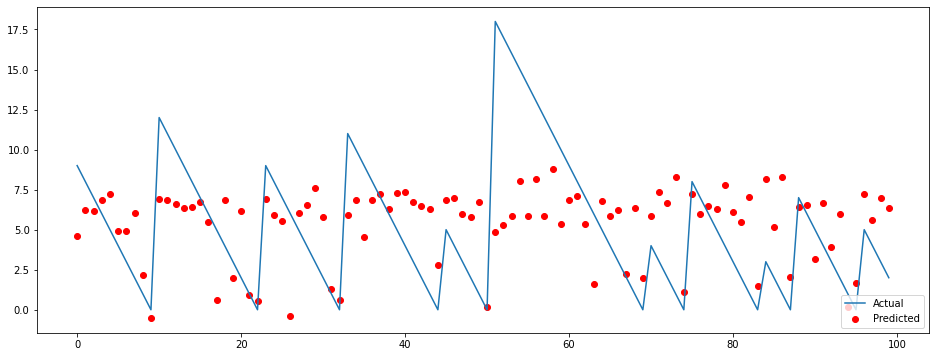

In [41]:
plt.figure(figsize=(16, 6))
plt.plot(SVR_trainY_arr[0:100])
plt.scatter(SVR_trainTime[0:100], SVR_trainPredict2[0:100], color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

In [42]:
#evaluate performance of validation set 
SVR_valPredict2 = SVRmodel2.predict(SVR_valX_degrad_arr)
SVR_valRMSE2 = math.sqrt(mean_squared_error(SVR_valY_degrad_arr, SVR_valPredict2))
SVR_valR2Score2 = r2_score(SVR_valY_degrad_arr, SVR_valPredict2)
SVR_valSscore2 = findSscore(SVR_valY_degrad_arr, SVR_valPredict2)
print("RMSE of validation set is %f, R2 score of validation set is %f, S score of validation set is %f" % (SVR_valRMSE2, SVR_valR2Score2, SVR_valSscore2))

RMSE of validation set is 3.840784, R2 score of validation set is 0.191011, S score of validation set is 1294.529626


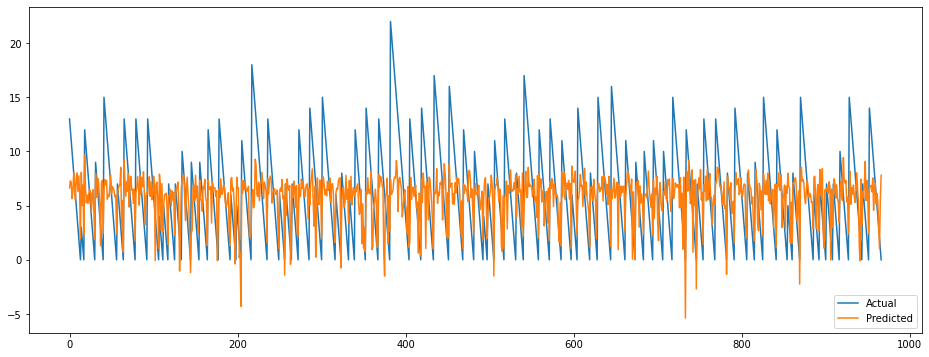

In [43]:
plt.figure(figsize=(16, 6))
plt.plot(SVR_valY_degrad_arr)
plt.plot(SVR_valPredict2)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

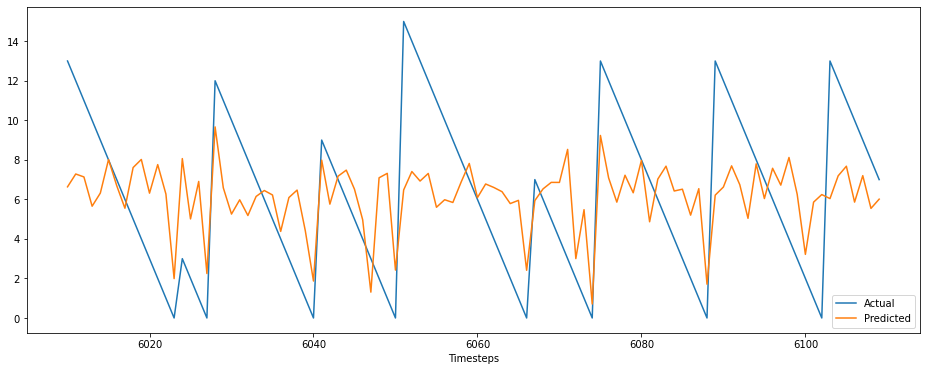

In [44]:
plt.figure(figsize=(16, 6))
plt.plot(SVR_valTime_degrad[0:100], SVR_valY_degrad_arr[0:100])
plt.plot(SVR_valTime_degrad[0:100], SVR_valPredict2[0:100])
plt.xlabel('Timesteps')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

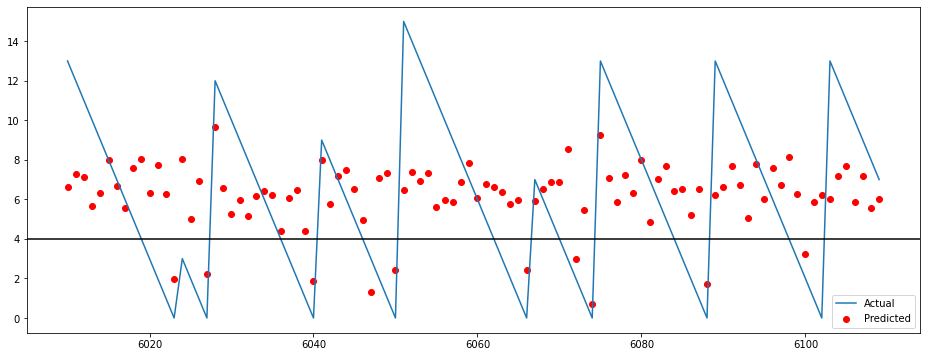

In [45]:
plt.figure(figsize=(16, 6))
plt.plot(SVR_valTime_degrad[0:100], SVR_valY_degrad_arr[0:100])
plt.scatter(SVR_valTime_degrad[0:100], SVR_valPredict2[0:100], color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.axhline(y=4, color='k', linestyle='-')
plt.show()